In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

In [2]:
# Gene-level expression (genes x samples)
expr = pd.read_csv("gene_expression_matrix.csv", index_col=0)

# Labels
labels = pd.read_csv("labels_final.csv", index_col=0)["Label"]

print("Expression shape:", expr.shape)
print("Labels shape:", labels.shape)
print(labels.value_counts())

Expression shape: (5642, 165)
Labels shape: (165,)
Label
1    147
0     18
Name: count, dtype: int64


In [3]:
common_samples = expr.columns.intersection(labels.index)

expr = expr[common_samples]
labels = labels.loc[common_samples]

print("Aligned expression:", expr.shape)
print("Aligned labels:", labels.shape)

Aligned expression: (5642, 165)
Aligned labels: (165,)


In [4]:
deg = pd.read_csv("DEG_results.csv")

# Select significant DEGs
deg_filtered = deg[
    (deg["adj_p_value"] < 0.05) &
    (abs(deg["log2FC"]) > 1)
]

top_genes = deg_filtered["Gene"].unique().tolist()

print("Selected DEGs:", len(top_genes))

Selected DEGs: 40


In [5]:
expr = expr.loc[expr.index.intersection(top_genes)]
print("Expression after DEG filtering:", expr.shape)

Expression after DEG filtering: (40, 165)


In [6]:
# ML format: samples x features
X = expr.T
y = labels.values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (165, 40)
y shape: (165,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 123
Test samples: 42


In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
logreg = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_lr))

print("ROC-AUC:",
      roc_auc_score(y_test, y_prob_lr))

print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9761904761904762
ROC-AUC: 0.9891891891891892
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.97      0.99        37

    accuracy                           0.98        42
   macro avg       0.92      0.99      0.95        42
weighted avg       0.98      0.98      0.98        42



In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:",
      accuracy_score(y_test, y_pred_rf))

print("ROC-AUC:",
      roc_auc_score(y_test, y_prob_rf))

print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9285714285714286
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.93      1.00      0.96        37

    accuracy                           0.93        42
   macro avg       0.96      0.70      0.77        42
weighted avg       0.93      0.93      0.91        42



<Figure size 700x600 with 0 Axes>

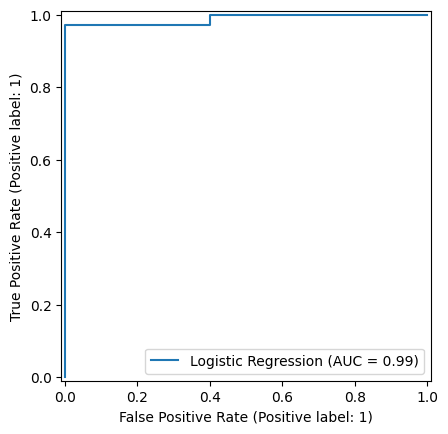

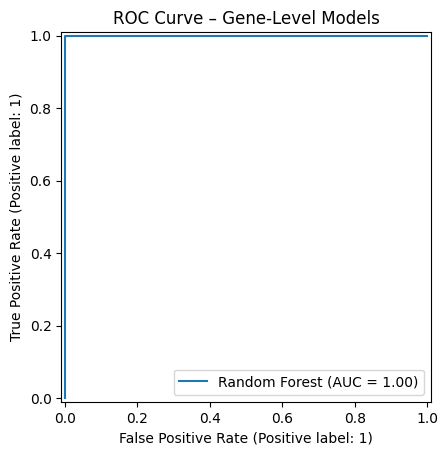

In [11]:
plt.figure(figsize=(7, 6))

RocCurveDisplay.from_predictions(
    y_test, y_prob_lr,
    name="Logistic Regression"
)

RocCurveDisplay.from_predictions(
    y_test, y_prob_rf,
    name="Random Forest"
)

plt.title("ROC Curve – Gene-Level Models")
plt.show()

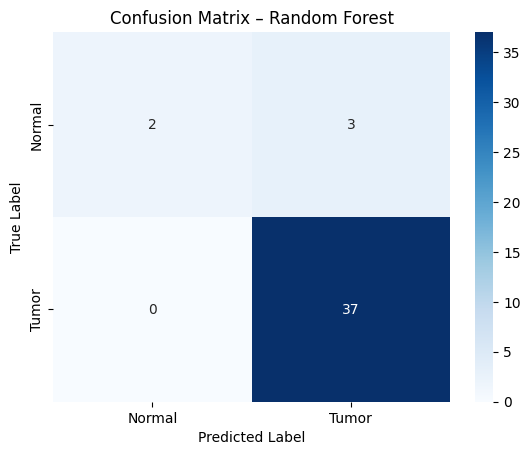

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Tumor"],
    yticklabels=["Normal", "Tumor"]
)

plt.title("Confusion Matrix – Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

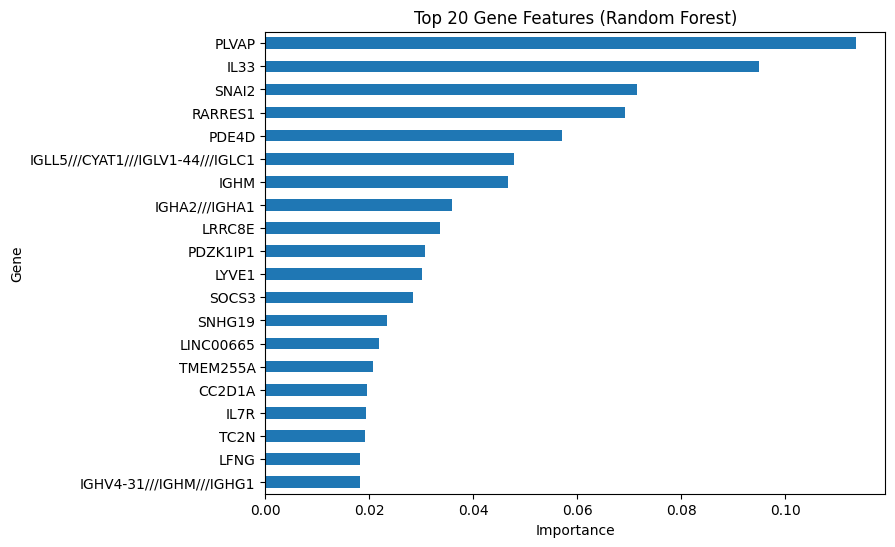

In [13]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

top_features = importances.head(20)

plt.figure(figsize=(8, 6))
top_features[::-1].plot(kind="barh")
plt.title("Top 20 Gene Features (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [14]:
# Save DEG-filtered gene expression matrix
expr.to_csv("gene_expression_DEG_40.csv")

print("Saved: gene_expression_DEG_40.csv")

Saved: gene_expression_DEG_40.csv
